In [0]:
import torch
import numpy as np
import torchvision.datasets as datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

In [0]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='data',train=False,download=True,transform=transform)
num_workers = 0
batch_size = 30
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

0it [00:00, ?it/s]

9920512it [00:01, 8006675.40it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135350.76it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 1908775.66it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 47610.57it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


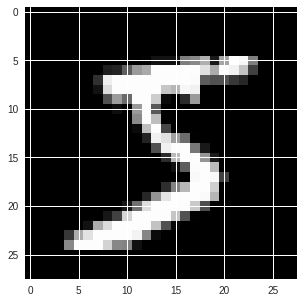

In [0]:
data = iter(train_loader)
images, labels = data.next()
images = images.numpy() #convert the tensor to numpy array
img = np.squeeze(images[0])#flatten out the image
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [0]:
class Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser,self).__init__()
            #encoder layers
        self.conv1 = nn.Conv2d(1,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,16,3,padding=1)
        self.conv3 = nn.Conv2d(16,8,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
            #decoder layers
        self.deconv1 = nn.ConvTranspose2d(8,8,3,stride=2)
        self.deconv2 = nn.ConvTranspose2d(8,16,2,stride=2)
        self.deconv3 = nn.ConvTranspose2d(16,32,2,stride=2)
        self.conv_out = nn.Conv2d(32,1,3,padding=1)
            
    def forward(self,x):
        #define the complete network
        #encoder
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        #decoder
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.conv_out(x))
        
        return x

model = Denoiser()
print(model)

Denoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (deconv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (deconv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (deconv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [0]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [23]:
epochs = 30
noise_factor = 0.6
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
  device = "cpu"
else:
  print('CUDA is available!  Training on GPU ...')
  device = "cuda"
model.to(device)


for epoch in range(1,epochs+1):
    train_loss = 0.0
    for data in train_loader:
        images,_ = data
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        optimizer.zero_grad()
        output = model(noisy_imgs.to(device))
        loss = loss_function(output,images.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,train_loss))

CUDA is available!  Training on GPU ...
Epoch: 1 	Training Loss: 1.500923
Epoch: 2 	Training Loss: 1.055069
Epoch: 3 	Training Loss: 0.970344
Epoch: 4 	Training Loss: 0.908010
Epoch: 5 	Training Loss: 0.876958
Epoch: 6 	Training Loss: 0.855166
Epoch: 7 	Training Loss: 0.839564
Epoch: 8 	Training Loss: 0.823737
Epoch: 9 	Training Loss: 0.812463
Epoch: 10 	Training Loss: 0.798363
Epoch: 11 	Training Loss: 0.783455
Epoch: 12 	Training Loss: 0.771834
Epoch: 13 	Training Loss: 0.758741
Epoch: 14 	Training Loss: 0.745678
Epoch: 15 	Training Loss: 0.734402
Epoch: 16 	Training Loss: 0.722479
Epoch: 17 	Training Loss: 0.714132
Epoch: 18 	Training Loss: 0.705207
Epoch: 19 	Training Loss: 0.697794
Epoch: 20 	Training Loss: 0.688336
Epoch: 21 	Training Loss: 0.683798
Epoch: 22 	Training Loss: 0.680277
Epoch: 23 	Training Loss: 0.675582
Epoch: 24 	Training Loss: 0.671411
Epoch: 25 	Training Loss: 0.669445
Epoch: 26 	Training Loss: 0.666060
Epoch: 27 	Training Loss: 0.661705
Epoch: 28 	Training Loss

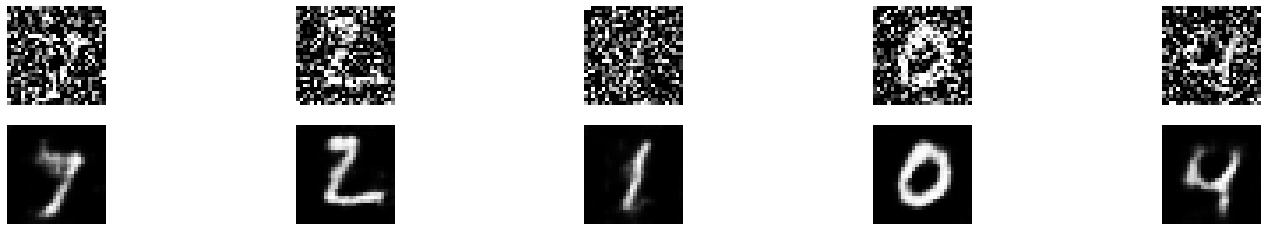

In [31]:
data = iter(test_loader)
images,labels = data.next()
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)
output = model(noisy_imgs.to(device))
noisy_imgs = noisy_imgs.numpy()
output = output.view(batch_size, 1, 28, 28)
output = output.cpu()
output = output.detach().numpy()
fig, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(25,4))
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)